In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity: ROI-wise.

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [6]:
import torch
use_device = "cuda:0"
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device(use_device) #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.0+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


# File locations

In [4]:
#input_dir = root_dir + "../nsd/output/multisubject/"
#joined_model_dir = input_dir + 'gnet8j_mpf_evc_Jan-18-2022_1148/' # 'gnet8j_mpf_evc_Jan-18-2022_1148/'
#roiwise_model_dir = input_dir + 'gnet8r_mpf_evc_Jan-17-2022_1738/'# 'gnet8r_mpf_evc_Jan-17-2022_1738/'

input_dir = root_dir + "output/multisubject/"
joined_model_dir = input_dir + 'gnet8j_mpf_evc_Feb-04-2022_1818/' 
roiwise_model_dir = input_dir + 'gnet8r_mpf_evc_Feb-05-2022_2105/'# 'gnet8r_mpf_evc_Feb-04-2022_1844/'

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

output_dir = joined_model_dir

# Reload joined GNet model files

In [7]:
joined_checkpoint = torch.load(joined_model_dir + 'model_params', map_location=use_device)
print (joined_checkpoint.keys())

dict_keys(['num_epochs', 'batch_size', 'holdout_frac', 'best_params', 'final_params', 'trn_loss_history', 'hold_loss_history', 'hold_cc_history', 'best_epoch', 'best_joint_cc_score', 'val_cc', 'input_mean', 'brain_nii_shape', 'voxel_index', 'voxel_roi', 'voxel_mask'])


## Voxel masks

In [8]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

roi_group_names = ['V1', 'V2', 'V3', 'hV4']
roi_group = [[1,2],[3,4],[5,6], [7]]

In [9]:
subjects = list(joined_checkpoint['voxel_mask'].keys())
gnet8j_voxel_mask = joined_checkpoint['voxel_mask']
gnet8j_voxel_roi  = joined_checkpoint['voxel_roi']
gnet8j_voxel_index= joined_checkpoint['voxel_index']
gnet8j_brain_nii_shape= joined_checkpoint['brain_nii_shape']
gnet8j_val_cc = joined_checkpoint['val_cc']

# Reload ROI-wise models

In [10]:
roiwise_model_dirs = {
    'V1': '%smodel_params_V1' % roiwise_model_dir,
    'V2': '%smodel_params_V2' % roiwise_model_dir,
    'V3': '%smodel_params_V3' % roiwise_model_dir,
    'hV4': '%smodel_params_hV4' % roiwise_model_dir
    }

roiwise_checkpoint = {}
for r,t in roiwise_model_dirs.items():
    roiwise_checkpoint[r] = torch.load(t, map_location=use_device)

In [11]:
cp = roiwise_checkpoint[list(roiwise_model_dirs.keys())[0]]
subjects = list(cp['voxel_mask'].keys())
gnet8r_voxel_mask = cp['voxel_mask']
gnet8r_voxel_roi  = cp['voxel_roi']
gnet8r_voxel_index= cp['voxel_index']
gnet8r_brain_nii_shape= cp['brain_nii_shape']
#these masks should be the same for all model components

In [12]:
gnet8r_val_cc = {s: np.zeros_like(v).astype(np.float32) for s,v in gnet8r_voxel_roi.items()}

for k,(roi_name, cp) in enumerate(roiwise_checkpoint.items()):
    for s in gnet8r_voxel_roi.keys():
        
        group_mask = cp['group_mask'][s]
        gnet8r_val_cc[s][group_mask] = cp['val_cc'][s]

---
# Load NSD Data
## Load NSD voxel data

In [13]:
voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = voxel_data_dict['voxel_data']

voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part2.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data.update(voxel_data_dict['voxel_data'])

voxel_data = {int(s): v for s,v in voxel_data.items()}
print (voxel_data.keys())

dict_keys([1, 2, 5, 6, 3, 4, 7, 8])


# Load the stimuli images
From the subjectwise image preparation

In [16]:
from src.load_nsd import image_feature_fn

stim_data = {}
for s in subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    stim_data[s] = image_feature_fn(np.copy(image_data_set['stimuli']))
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', stim_data[s].shape, ', dtype:', stim_data[s].dtype, ', value range:',\
           np.min(stim_data[s][0]), np.max(stim_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0


## Data split

In [17]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

In [18]:
from src.load_nsd import ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

data_size, nnv = {}, {}
for k,s in enumerate(voxel_data.keys()):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape 

    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)

del voxel_data

--------  subject 1  -------
Total number of voxels = 4627
--------  subject 2  -------
Total number of voxels = 3765
--------  subject 5  -------
Total number of voxels = 3685
--------  subject 6  -------
Total number of voxels = 4024
--------  subject 3  -------
Total number of voxels = 3778
--------  subject 4  -------
Total number of voxels = 3027
--------  subject 7  -------
Total number of voxels = 3201
--------  subject 8  -------
Total number of voxels = 3490


# Noise inference

In [ ]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))
    
def cross_validated_covariance_target(image_pred, ordering, voxel_data):
    C, Cp, Ap = {}, {}, {}
    for s,p,o,d in zip_dict(image_pred, ordering, voxel_data):
        val_pred = p[o]
        C[s]  = np.corrcoef(d.T)
        Cp[s] = np.corrcoef(d.T, val_pred.T)[:d.shape[1], val_pred.shape[1]:]
        Ap[s] = np.corrcoef(val_pred.T)
    return C, Cp, Ap

def optimize_noise(C, Cp, Ap, step_size, n_steps, loss_th):
    '''find the best parameters B and R of
    \bar r = B p + R n, where \bar r is a new fake noise voxel series and p is the model prediction and r the actual series such that
    \rho(p, \bar r) = \rho(p, r) and cov(\bar r)=cov(r)
    In other words, it is about finding the best noise covariance such that the new series matches the data covariance, while taking into account the signal covariance.
    Since that problem is overconstrained, we optimize for a solution.
    '''
    
    def step(Rd, RRd, step_size):
        D = torch.tensordot(Rd, torch.transpose(Rd, 0, 1), dims=[[1],[0]]) - RRd
        loss = (D**2).sum()
        Rd -= step_size * torch.tensordot(torch.transpose(D, 0, 1), Rd, dims=[[1],[0]])
        return loss    
    
    Bs, Rs, Loss_hs = {}, {}, {}
    for s, cc, cp, ap in zip_dict(C, Cp, Ap):
        print ('subject %s'%s)
        B = []
        for c,a in zip(cp, ap):
            B += [np.sum(c*a) / np.sum(a**2),]
        B = np.array(B)
        R = np.diag(np.sqrt(1. - B**2)) + np.random.normal(0,.1,size=(len(B),len(B))).astype(np.float32)
        RR = cc - np.dot(np.diag(B), np.dot(ap, np.diag(B)))

        Rd  = torch.tensor(R,  requires_grad=False).to(device)
        RRd = torch.tensor(RR, requires_grad=False).to(device)

        loss_h = []
        for t in tqdm(range(n_steps)):
            loss_h += [get_value(step(Rd, RRd, step_size)),]
            if loss_h[-1]<loss_th:
                break

        Loss_hs[s] = loss_h
        Bs[s] = B
        Rs[s] = get_value(Rd) 
    return Bs, Rs, Loss_hs 

## Rebuild model
Prediction will take a considerable amount of time.

In [26]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, torch.from_numpy(xb).to(device))

In [27]:
import imp
import src.tuning as aaa
imp.reload(aaa)

<module 'src.tuning' from '/export/raid1/home/styvesg/code/nsd_gnet8x/src/tuning.py'>

In [28]:
# due to allocation issue at one time, the specific model instanciation is baked into these methods.
from src.tuning import gnet8j_predictions, gnet8r_predictions

---
# Predictions for all NSD images
## GNet8j

In [41]:
gnet8j_image_pred = gnet8j_predictions(stim_data, _pred_fn, joined_checkpoint, batch_size=100, device=device)

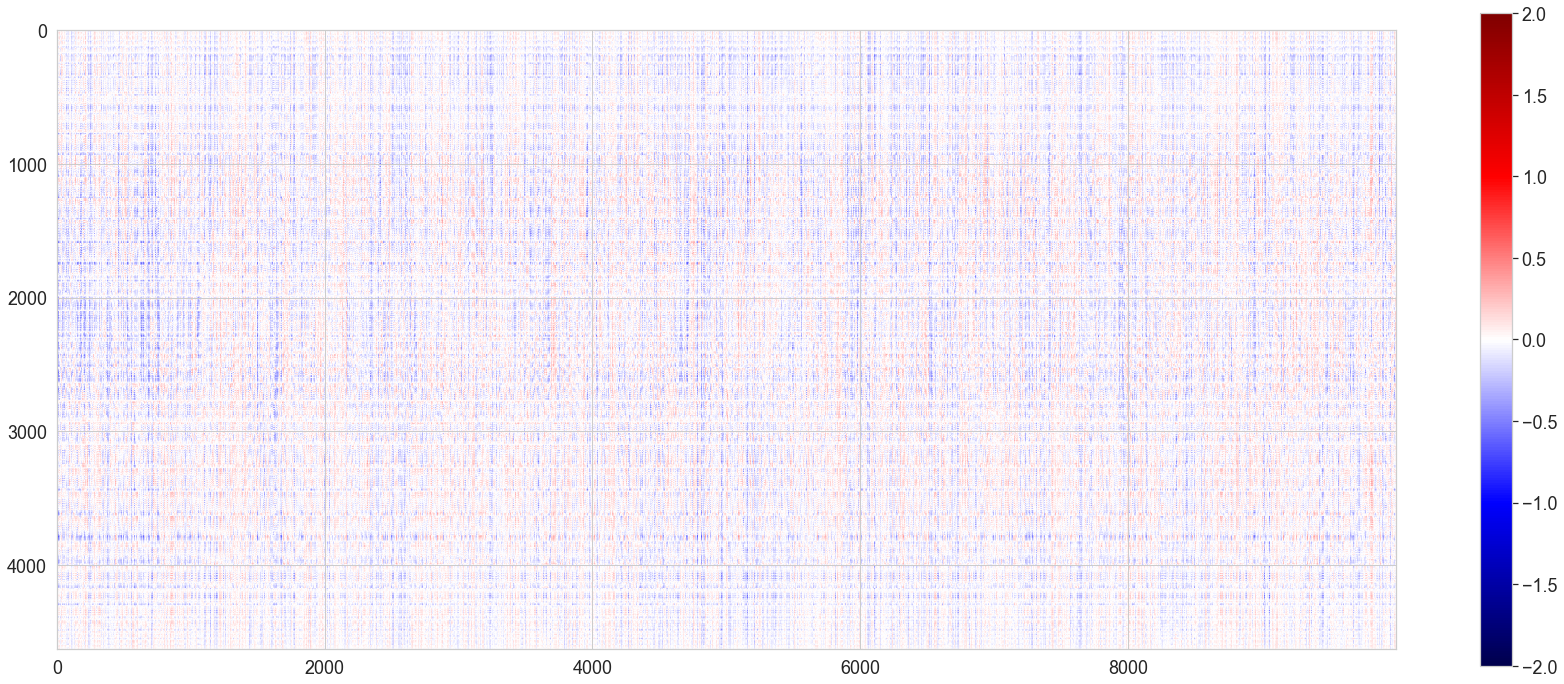

In [42]:
plt.figure(figsize=(30,12))
plt.imshow(gnet8j_image_pred[1].T, cmap='seismic', vmin=-2, vmax=2)
plt.colorbar()

In [43]:
val_cc = {s: np.zeros(v.shape[1]) for s,v in val_voxel_data.items()}
for s,p,o,v in zip_dict(gnet8j_image_pred, val_stim_ordering, val_voxel_data):
    for i in range(v.shape[1]):
        val_cc[s][i] = np.corrcoef(p[o,i], v[:,i])[0,1]

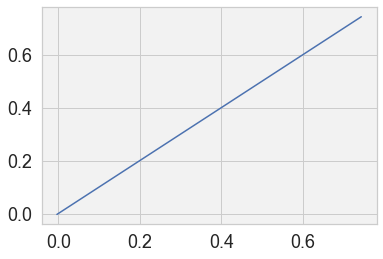

In [44]:
subj = 1
idx = np.argsort(val_cc[subj])

plt.figure(figsize=(6,4))
plt.plot(gnet8j_val_cc[subj][idx], val_cc[subj][idx])

In [57]:
step_size = 1e-3
n_steps = 20000 # 10K
loss_th = 4

C, Cp, Ap = cross_validated_covariance_target(gnet8j_image_pred, val_stim_ordering, val_voxel_data)
Bs, Rs, Loss_hs = optimize_noise(C, Cp, Ap, step_size, n_steps, loss_th)

subject 1


100%|██████████| 20000/20000 [09:49<00:00, 33.90it/s]


subject 2


100%|██████████| 20000/20000 [05:21<00:00, 62.19it/s]


subject 3


100%|██████████| 20000/20000 [05:30<00:00, 60.55it/s]


subject 4


100%|██████████| 20000/20000 [02:54<00:00, 114.43it/s]


subject 5


100%|██████████| 20000/20000 [05:05<00:00, 65.48it/s]


subject 6


100%|██████████| 20000/20000 [06:43<00:00, 49.52it/s]


subject 7


 50%|████▉     | 9951/20000 [01:43<01:44, 96.10it/s]


subject 8


100%|██████████| 20000/20000 [04:21<00:00, 76.50it/s]


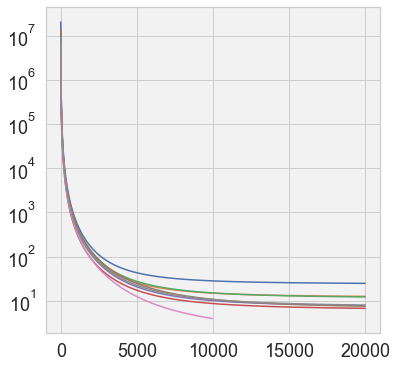

In [58]:
plt.figure(figsize=(6,6))
for s,h in Loss_hs.items():
    plt.plot(h, label=s)
plt.yscale('log')

In [59]:
pred_data = {'pred': gnet8j_image_pred,
            'val_cc': gnet8j_val_cc,
            'voxel_roi': gnet8j_voxel_roi,
            'voxel_mask': gnet8j_voxel_mask,
            'voxel_index': gnet8j_voxel_index,
            'brain_nii_shape': gnet8j_brain_nii_shape ,
            'Bs': Bs, 
            'Rs': Rs
           }

save_stuff( joined_model_dir + 'V1_4_pred', flatten_dict(pred_data))

saved pred.1 in h5py file
saved pred.2 in h5py file
saved pred.3 in h5py file
saved pred.4 in h5py file
saved pred.5 in h5py file
saved pred.6 in h5py file
saved pred.7 in h5py file
saved pred.8 in h5py file
saved val_cc.1 in h5py file
saved val_cc.2 in h5py file
saved val_cc.3 in h5py file
saved val_cc.4 in h5py file
saved val_cc.5 in h5py file
saved val_cc.6 in h5py file
saved val_cc.7 in h5py file
saved val_cc.8 in h5py file
saved voxel_roi.1 in h5py file
saved voxel_roi.2 in h5py file
saved voxel_roi.3 in h5py file
saved voxel_roi.4 in h5py file
saved voxel_roi.5 in h5py file
saved voxel_roi.6 in h5py file
saved voxel_roi.7 in h5py file
saved voxel_roi.8 in h5py file
saved voxel_mask.1 in h5py file
saved voxel_mask.2 in h5py file
saved voxel_mask.3 in h5py file
saved voxel_mask.4 in h5py file
saved voxel_mask.5 in h5py file
saved voxel_mask.6 in h5py file
saved voxel_mask.7 in h5py file
saved voxel_mask.8 in h5py file
saved voxel_index.1 in h5py file
saved voxel_index.2 in h5py fil

## GNet8r

In [36]:
gnet8r_image_pred = gnet8r_predictions(stim_data, _pred_fn, roiwise_checkpoint, batch_size=100, device=device)

predicting V1 voxels
predicting V2 voxels
predicting V3 voxels
predicting hV4 voxels


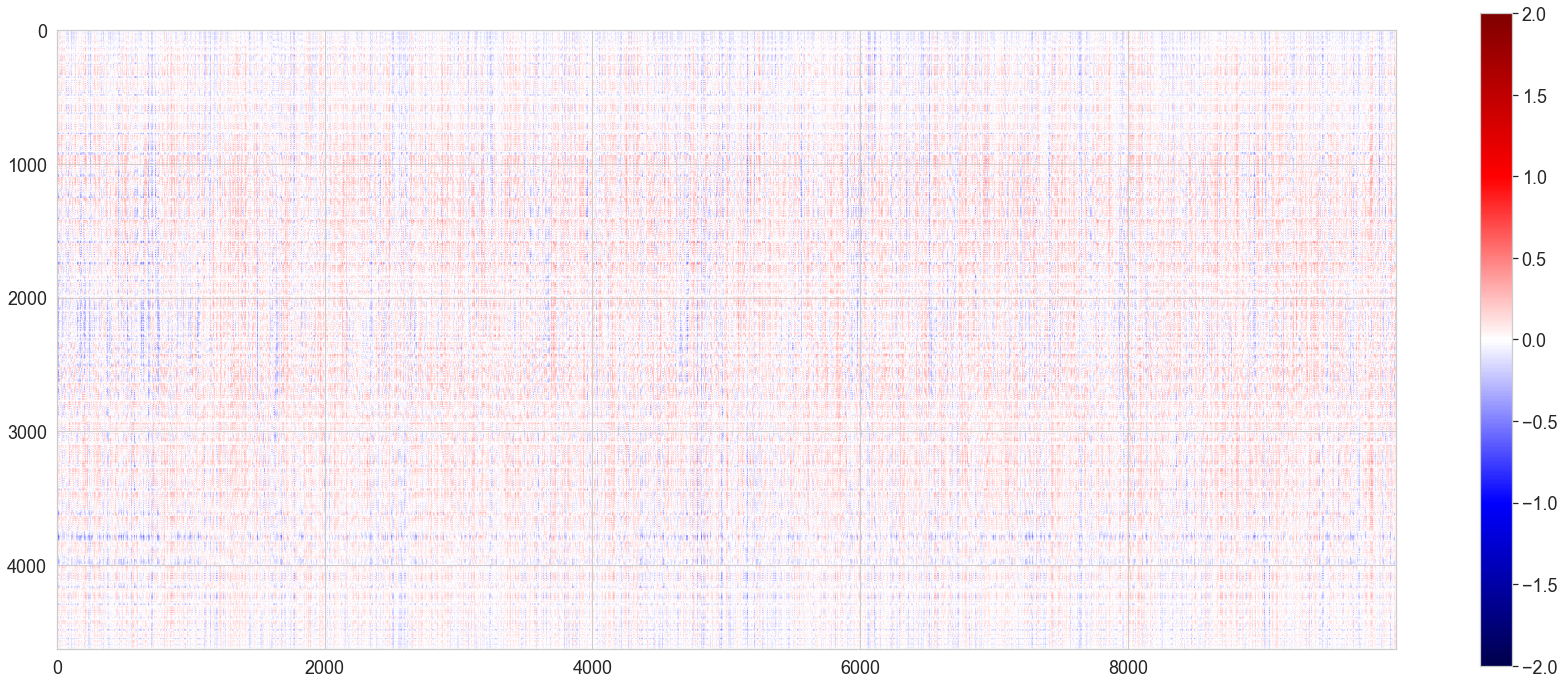

In [37]:
plt.figure(figsize=(30,12))
plt.imshow(gnet8r_image_pred[1].T, cmap='seismic', vmin=-2, vmax=2)
plt.colorbar()

In [38]:
val_cc = {s: np.zeros(v.shape[1]) for s,v in val_voxel_data.items()}
for s,p,o,v in zip_dict(gnet8r_image_pred, val_stim_ordering, val_voxel_data):
    for i in range(v.shape[1]):
        val_cc[s][i] = np.corrcoef(p[o,i], v[:,i])[0,1]

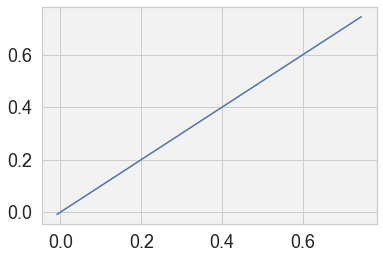

In [39]:
subj = 1
idx = np.argsort(val_cc[subj])

plt.figure(figsize=(6,4))
plt.plot(gnet8r_val_cc[subj][idx], val_cc[subj][idx])

In [ ]:
step_size = 1e-3
n_steps = 20000 # 10K
loss_th = 4

C, Cp, Ap = cross_validated_covariance_target(gnet8r_image_pred, val_stim_ordering, val_voxel_data)
Bs, Rs, Loss_hs = optimize_noise(C, Cp, Ap, step_size, n_steps, loss_th)

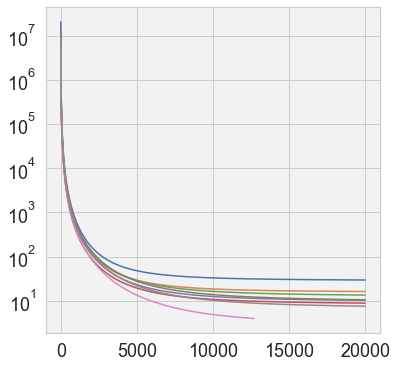

In [54]:
plt.figure(figsize=(6,6))
for s,h in Loss_hs.items():
    plt.plot(h, label=s)
plt.yscale('log')

In [56]:
pred_data = {'pred': gnet8r_image_pred,
            'val_cc': gnet8r_val_cc,
            'voxel_roi': gnet8r_voxel_roi,
            'voxel_mask': gnet8r_voxel_mask,
            'voxel_index': gnet8r_voxel_index,
            'brain_nii_shape': gnet8r_brain_nii_shape ,
            'Bs': Bs, 
            'Rs': Rs
           }

save_stuff( roiwise_model_dir + 'V1_4_pred', flatten_dict(pred_data))

saved pred.1 in h5py file
saved pred.2 in h5py file
saved pred.3 in h5py file
saved pred.4 in h5py file
saved pred.5 in h5py file
saved pred.6 in h5py file
saved pred.7 in h5py file
saved pred.8 in h5py file
saved val_cc.1 in h5py file
saved val_cc.2 in h5py file
saved val_cc.3 in h5py file
saved val_cc.4 in h5py file
saved val_cc.5 in h5py file
saved val_cc.6 in h5py file
saved val_cc.7 in h5py file
saved val_cc.8 in h5py file
saved voxel_roi.1 in h5py file
saved voxel_roi.2 in h5py file
saved voxel_roi.3 in h5py file
saved voxel_roi.4 in h5py file
saved voxel_roi.5 in h5py file
saved voxel_roi.6 in h5py file
saved voxel_roi.7 in h5py file
saved voxel_roi.8 in h5py file
saved voxel_mask.1 in h5py file
saved voxel_mask.2 in h5py file
saved voxel_mask.3 in h5py file
saved voxel_mask.4 in h5py file
saved voxel_mask.5 in h5py file
saved voxel_mask.6 in h5py file
saved voxel_mask.7 in h5py file
saved voxel_mask.8 in h5py file
saved voxel_index.1 in h5py file
saved voxel_index.2 in h5py fil

In [ ]:
## load 
#pred_set = h5py.File(roiwise_model_dir + 'V1_4_pred.h5py', 'r')
#pred_data = embed_dict({k:np.copy(v) for k,v in pred_set.items()})
#pred_set.close()
#print (pred_data.keys())